In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

pd.plotting.register_matplotlib_converters()

In [2]:
#labeling column names for the txt file that will be brought in
colnames=['date','time','page_viewed','user_id','cohort_id','ip']

#bringing in the txt file
df = pd.read_csv('anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames, #will be labeling the the columns the names above
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,1,2,3,4,5]) #only using these specified columns

df

,date,time,page_viewed,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
719454,2020-11-02,16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199
719455,2020-11-02,16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175
719456,2020-11-02,16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175
719457,2020-11-02,16:48:28,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175


In [3]:
colnames=['cohort_id','name','start_date','end_date','program_id']
df_cohort = pd.read_csv('cohorts.csv',
                       names=colnames, 
                       skiprows=1,
                       usecols=[0,1,2,3,4])
#print(df_cohort.info())
df_cohort

,cohort_id,name,start_date,end_date,program_id
0,1,Arches,2014-02-04,2014-04-22,1
1,2,Badlands,2014-06-04,2014-08-22,1
2,3,Carlsbad,2014-09-04,2014-11-05,1
3,4,Denali,2014-10-20,2015-01-18,1
4,5,Everglades,2014-11-18,2015-02-24,1
5,6,Franklin,2015-02-03,2015-05-26,1
6,7,Glacier,2015-06-05,2015-10-06,1
7,8,Hampton,2015-09-22,2016-02-06,1
8,9,Apollo,2015-03-30,2015-07-29,4
9,10,Balboa,2015-11-03,2016-03-11,4


In [4]:
df = df.merge(df_cohort, on='cohort_id', how='left')
df.head()

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0


### How many nulls do we have?

In [5]:
df.user_id.isna().sum()

0

In [6]:
df.cohort_id.isna().sum()

44840

### Quite a bit of nulls, Lets break it down by cohort

In [7]:
len(df.cohort_id.value_counts())

40

In [8]:
len(df_cohort.cohort_id.value_counts())

46

### We have 6 cohorts missing, which ones are they?

In [9]:
#cohorts = pd.DataFrame(columns = [df.cohort_id, df_cohort.cohort_id])

dfc= df_cohort.cohort_id.value_counts().index
dfco = df.cohort_id.value_counts().index

print('The missing cohorts are: ', set(dfc) - set(dfco))
df_cohort.loc[(df_cohort['cohort_id'] == 3)|(df_cohort['cohort_id'] == 132)|(df_cohort['cohort_id'] == 10)|(df_cohort['cohort_id'] == 20)|(df_cohort['cohort_id'] == 60)|(df_cohort['cohort_id'] == 30)]


The missing cohorts are:  {3, 132, 10, 20, 60, 30}


,cohort_id,name,start_date,end_date,program_id
2,3,Carlsbad,2014-09-04,2014-11-05,1
9,10,Balboa,2015-11-03,2016-03-11,4
19,20,Redwood,2017-07-31,2017-12-06,2
29,30,Ada,2019-02-04,2019-06-16,3
42,60,Io,2020-07-20,2021-01-21,2
45,132,Kalypso,2020-11-02,2021-05-04,2


### Lets create 2 different dataframes for the null values and non null values

In [10]:
df2 = df[df.cohort_id.isna()]
df2.cohort_id.fillna(0, inplace=True)
df2

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
411,2018-01-26,16:46:16,/,48,0.0,97.105.19.61,NaN,NaN,NaN,NaN
412,2018-01-26,16:46:24,spring/extra-features/form-validation,48,0.0,97.105.19.61,NaN,NaN,NaN,NaN
425,2018-01-26,17:54:24,/,48,0.0,97.105.19.61,NaN,NaN,NaN,NaN
435,2018-01-26,18:32:03,/,48,0.0,97.105.19.61,NaN,NaN,NaN,NaN
436,2018-01-26,18:32:17,mysql/relationships/joins,48,0.0,97.105.19.61,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
719411,2020-11-02,16:02:22,java-iii,717,0.0,136.50.18.157,NaN,NaN,NaN,NaN
719412,2020-11-02,16:02:26,java-iii/servlets,717,0.0,136.50.18.157,NaN,NaN,NaN,NaN
719414,2020-11-02,16:03:50,appendix/further-reading/java/intellij-tomcat-...,727,0.0,70.94.165.107,NaN,NaN,NaN,NaN
719416,2020-11-02,16:04:18,java-iii/servlets,727,0.0,70.94.165.107,NaN,NaN,NaN,NaN


In [11]:
df = df.dropna()
df

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...,...
719454,2020-11-02,16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,Jupiter,2020-09-21,2021-03-30,2.0
719455,2020-11-02,16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0
719456,2020-11-02,16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0
719457,2020-11-02,16:48:28,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0


### From here, lets break it down from web dev to DS

In [12]:
df.program_id.value_counts()

2.0    576508
3.0     68016
1.0     30089
4.0         5
Name: program_id, dtype: int64

In [13]:
df[df['program_id'] == 1]

# Program 1 seems to be Web Dev

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
30,2018-01-26,10:14:47,/,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0
...,...,...,...,...,...,...,...,...,...,...
668987,2020-09-13,14:43:04,content/php_iv/exceptions/try-catch.html,210,17.0,71.56.144.20,Olympic,2017-02-06,2017-05-25,1.0
668988,2020-09-13,14:43:10,content/php_iv/classes-and-objects-ii,210,17.0,71.56.144.20,Olympic,2017-02-06,2017-05-25,1.0
668989,2020-09-13,14:43:12,content/php_iv/classes-and-objects-ii/visibili...,210,17.0,71.56.144.20,Olympic,2017-02-06,2017-05-25,1.0
668990,2020-09-13,14:43:38,content/php_iv/classes-and-objects-ii/magic-me...,210,17.0,71.56.144.20,Olympic,2017-02-06,2017-05-25,1.0


In [14]:
df[df['program_id'] == 2]

# Program 2 seems to be Web Dev

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
5,2018-01-26,09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
6,2018-01-26,09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
7,2018-01-26,09:56:48,javascript-i/functions,3,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
8,2018-01-26,09:56:59,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...,...
719454,2020-11-02,16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,Jupiter,2020-09-21,2021-03-30,2.0
719455,2020-11-02,16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0
719456,2020-11-02,16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0
719457,2020-11-02,16:48:28,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0


In [15]:
df[df['program_id'] == 3]

# Program 3 seems to be Data Science

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
326053,2019-08-20,09:39:58,/,466,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326054,2019-08-20,09:39:59,/,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326055,2019-08-20,09:39:59,/,468,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326056,2019-08-20,09:40:02,/,469,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326057,2019-08-20,09:40:08,/,470,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
...,...,...,...,...,...,...,...,...,...,...
719391,2020-11-02,15:50:07,appendix/open_data,698,59.0,24.28.150.196,Darden,2020-07-13,2021-01-12,3.0
719396,2020-11-02,15:52:23,timeseries/sarimax,698,59.0,24.28.150.196,Darden,2020-07-13,2021-01-12,3.0
719400,2020-11-02,15:57:22,/,616,55.0,70.114.9.241,Curie,2020-02-03,2020-07-07,3.0
719401,2020-11-02,15:57:25,search/search_index.json,616,55.0,70.114.9.241,Curie,2020-02-03,2020-07-07,3.0


In [16]:
df[df['program_id'] == 4]

# Program 4 looks to be Web Dev

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
31627,2018-03-22,19:01:49,/,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0
31628,2018-03-22,19:01:54,content/html-css,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0
31629,2018-03-22,19:01:54,content/html-css/gitbook/images/favicon.ico,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0
31630,2018-03-22,19:02:47,content/html-css,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0
31631,2018-03-22,19:02:52,content/html-css/introduction.html,152,9.0,207.68.209.17,Apollo,2015-03-30,2015-07-29,4.0


In [17]:
# We'll group up the program Id's into Dataframes for better exploration

df_ds = df[df['program_id'] == 3]
df_ds


,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
326053,2019-08-20,09:39:58,/,466,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326054,2019-08-20,09:39:59,/,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326055,2019-08-20,09:39:59,/,468,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326056,2019-08-20,09:40:02,/,469,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
326057,2019-08-20,09:40:08,/,470,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0
...,...,...,...,...,...,...,...,...,...,...
719391,2020-11-02,15:50:07,appendix/open_data,698,59.0,24.28.150.196,Darden,2020-07-13,2021-01-12,3.0
719396,2020-11-02,15:52:23,timeseries/sarimax,698,59.0,24.28.150.196,Darden,2020-07-13,2021-01-12,3.0
719400,2020-11-02,15:57:22,/,616,55.0,70.114.9.241,Curie,2020-02-03,2020-07-07,3.0
719401,2020-11-02,15:57:25,search/search_index.json,616,55.0,70.114.9.241,Curie,2020-02-03,2020-07-07,3.0


In [18]:
df_wd = df[df['program_id'] != 3]
df_wd

,date,time,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...,...
719454,2020-11-02,16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,Jupiter,2020-09-21,2021-03-30,2.0
719455,2020-11-02,16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0
719456,2020-11-02,16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0
719457,2020-11-02,16:48:28,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0


In [19]:
# How many cohorts are there in each dataframe?

df_ds['cohort_id'].value_counts()

34.0    25181
59.0    22425
55.0    20410
Name: cohort_id, dtype: int64

In [20]:
df_wd['cohort_id'].value_counts()

28.0    60315
33.0    40168
29.0    37548
53.0    36047
24.0    35624
57.0    32447
56.0    31670
22.0    30328
51.0    29688
58.0    28354
32.0    28333
23.0    28329
26.0    27637
52.0    27518
25.0    25427
31.0    25253
27.0    20447
61.0    11774
14.0     9495
1.0      8884
62.0     8718
21.0     7444
17.0     4925
13.0     2733
18.0     2005
8.0      1712
19.0     1165
16.0      743
15.0      691
7.0       495
12.0      302
11.0      208
2.0        93
6.0        72
9.0         5
4.0         4
5.0         1
Name: cohort_id, dtype: int64

# <div class="alert alert-block alert-info">1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?</div>

### -A majority of the Data Science Cohorts tend to hit ```1-fundamentals/1.1-intro-to-data-science```

### -Webdev cohorts tend to hit the ```javascript-i``` page

In [21]:
# Turning the forward slash to home

df_ds.replace('/', 'home', inplace=True)
df_wd.replace('/', 'home', inplace=True)


In [22]:
df_ds.page_viewed.value_counts().head(20)

home                                                 5406
1-fundamentals/modern-data-scientist.jpg             1563
1-fundamentals/AI-ML-DL-timeline.jpg                 1559
1-fundamentals/1.1-intro-to-data-science             1536
search/search_index.json                             1331
6-regression/1-overview                              1123
classification/overview                               860
10-anomaly-detection/AnomalyDetectionCartoon.jpeg     745
10-anomaly-detection/1-overview                       742
3-sql/1-mysql-overview                                704
1-fundamentals/DataToAction_v2.jpg                    662
classification/scale_features_or_not.svg              642
1-fundamentals/1.2-data-science-pipeline              638
sql/mysql-overview                                    615
appendix/cli-git-overview                             579
5-stats/4.2-compare-means                             554
5-stats/3-probability-distributions                   525
3-sql/7-functi

In [23]:
df_wd.page_viewed.value_counts().head(20)

home                                                                         30669
javascript-i                                                                 13902
toc                                                                          13404
search/search_index.json                                                     12271
java-iii                                                                     10610
html-css                                                                     10363
java-ii                                                                       9956
spring                                                                        9699
jquery                                                                        8846
mysql                                                                         8774
java-i                                                                        8699
javascript-ii                                                                 8367
appe

#  <div class="alert alert-block alert-info">2. Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over?</div>

### - The Data Science Darden cohort had significant hits on the ```classification/overview``` page compared to the other cohorts.

### - 

In [24]:
df_ds.page_viewed.value_counts().head(30)

home                                                 5406
1-fundamentals/modern-data-scientist.jpg             1563
1-fundamentals/AI-ML-DL-timeline.jpg                 1559
1-fundamentals/1.1-intro-to-data-science             1536
search/search_index.json                             1331
6-regression/1-overview                              1123
classification/overview                               860
10-anomaly-detection/AnomalyDetectionCartoon.jpeg     745
10-anomaly-detection/1-overview                       742
3-sql/1-mysql-overview                                704
1-fundamentals/DataToAction_v2.jpg                    662
classification/scale_features_or_not.svg              642
1-fundamentals/1.2-data-science-pipeline              638
sql/mysql-overview                                    615
appendix/cli-git-overview                             579
5-stats/4.2-compare-means                             554
5-stats/3-probability-distributions                   525
3-sql/7-functi

In [36]:
# Getting the top ten lessons viewed ready to be graphed

dsl = df_ds[(df_ds.page_viewed == '1-fundamentals/1.1-intro-to-data-science')\
            |(df_ds.page_viewed == '6-regression/1-overview')\
            |(df_ds.page_viewed == 'classification/overview')\
            |(df_ds.page_viewed == '10-anomaly-detection/1-overview')\
            |(df_ds.page_viewed == '1-fundamentals/1.2-data-science-pipeline')\
            |(df_ds.page_viewed == 'sql/mysql-overview')\
            |(df_ds.page_viewed == '3-sql/1-mysql-overview')]


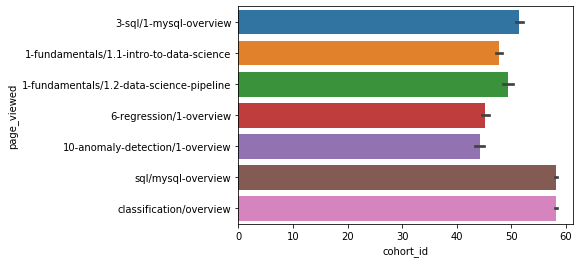

In [37]:
sns.barplot(x=dsl.cohort_id, y=dsl.page_viewed)

#sns.barplot(x=dsl.page_viewed, y=dsl.cohort_id)

In [68]:
dsl1 = pd.crosstab(dsl.cohort_id, dsl.page_viewed)
dsl1

page_viewed,1-fundamentals/1.1-intro-to-data-science,1-fundamentals/1.2-data-science-pipeline,10-anomaly-detection/1-overview,3-sql/1-mysql-overview,6-regression/1-overview,classification/overview,sql/mysql-overview
cohort_id,,,,,,,
34.0,615,221,383,142,521,10,3
55.0,461,146,345,441,595,91,99
59.0,460,271,14,121,7,759,513


In [58]:
plt.figure(figsize=(13,7))
x=x+1
for col in dsl1.columns:
    plt.subplot(1,2,x)
    x=x+1
    sns.barplot(x=dsl1.index, y=dsl1[col])


ValueError: num must be 1 <= num <= 2, not 16

<Figure size 936x504 with 0 Axes>

In [35]:
sns.factorplot(x='cohort_id', y='page_viewed', data=dsl, kind='bar')

ValueError: Could not interpret input 'cohort_id'